## Feature Estimation & PCA Analysis 
- This notebook is used to estimate the features of the neurons and perform PCA analysis. 
- Place Field Features: 
    - Peak Rate 
    - Average Rate
    - Place Field Width
    - Place Field Peak Location
    - Number of Place Fields
    - Percentage of Trials Close to Peak
    - Presence Ratio
- PCA Analysis: 
    - Perform PCA on the features
    - Plot the explained variance
    - Plot the PCA scores
    - Plot the PCA loadings






In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from convnwb.io import get_files, load_jsons_to_df
from scipy.stats import binom_test
from spiketools.plts.utils import make_grid, get_grid_subplot, save_figure
from spiketools.plts.style import drop_spines
from spiketools.utils.run import create_methods_list

In [3]:
import seaborn as sns
sns.set_context('talk', font_scale=0.9)

In [4]:
import sys
sys.path.append('../code')
from utils import find_place_field,find_place_location

sys.path.append('../scripts')
from settings import PATHS, METHODS

In [5]:
results_folder = PATHS['RESULTS'] / 'units'
reports_folder = PATHS['REPORTS'] / 'units'


In [6]:
locations_folder = PATHS['BASE'] / 'localization'/'Loc'
locations_files = get_files(locations_folder, select='session_data')
Locations = load_jsons_to_df(locations_files, folder=locations_folder)


In [7]:
# Get the list of files
res_files = get_files(results_folder, select='mat')

In [8]:
# Collect all unit results together into a dataframe
all_results = load_jsons_to_df(res_files, folder=results_folder)

In [9]:
# Get total number of units
n_units = len(all_results)
print('Total number of cells: {}'.format(n_units))
# Collect numbers of significant cells
analyses = create_methods_list(METHODS)
# Statistics settings
alpha_level = 0.05
binom_sidedness = 'greater'   
results = {}
for analysis in analyses:
    all_results[f'is_{analysis}'] = (all_results[f'{analysis}_surr_p_val'] < alpha_level).values

for analysis in analyses:
     results[analysis] = sum(all_results['is_' + analysis])


# Compute significance of the counts of detected neurons
all_stats = {}
for analysis in analyses:
    all_stats[analysis] = binom_test(results[analysis], n_units, alpha_level, binom_sidedness)

Total number of cells: 390


/var/folders/tx/9bxcz_2j6m79n4dmyyw6s2zm0000gn/T/ipykernel_21344/3223072776.py:20: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  all_stats[analysis] = binom_test(results[analysis], n_units, alpha_level, binom_sidedness)


In [10]:
# Check the number & percent of significant cells per analysis
print('total cells: {}\n'.format( n_units))
for analysis in analyses:
    print('# {} cells:     \t\t{:3d}  ({:5.2f}%) \t\t {:.4f}'.format(\
        analysis, results[analysis], results[analysis] / n_units * 100, all_stats[analysis]))

total cells: 390

# place_anova cells:     		 85  (21.79%) 		 0.0000
# place_info cells:     		 84  (21.54%) 		 0.0000
# place_fr_anova cells:     		 54  (13.85%) 		 0.0000
# place_fr_info cells:     		 63  (16.15%) 		 0.0000


In [11]:
spike_names = all_results['spike_name']
labels = all_results['label']

In [12]:
all_results['channel'] = spike_names.str.extract(r'(?:NSX|CSC)(\d+)')[0].str.lstrip('0')
all_results['sessions'] = all_results['session_id'].str.extract(r'(\w+)_(\d+)_train_events.mat')[0] + '_' + all_results['session_id'].str.extract(r'(\w+)_(\d+)_train_events.mat')[1]


## Get Features 

In [13]:
## Compute Features
# Initialize new columns with appropriate data types
all_results['peak_rate'] = np.nan
all_results['average_rate'] = np.nan
all_results['SNR'] = np.nan
all_results['place_field_bins'] = pd.Series([None] * len(all_results))
all_results['noise_bins'] = pd.Series([None] * len(all_results))
all_results['labeled_fields'] = pd.Series([None] * len(all_results))
all_results['N_place_fields'] = pd.Series([None] * len(all_results))
all_results['place_field_peak_location'] = pd.Series([None] * len(all_results))
all_results['trial_peak_loc'] = pd.Series([None] * len(all_results))
all_results['trial_peak_rate'] = pd.Series([None] * len(all_results))
all_results['num_trials_close_to_peak'] = pd.Series([None] * len(all_results))
all_results['percentage_num_trials_close_to_peak'] = pd.Series([None] * len(all_results))

# Calculate basic rate features
all_results['peak_rate'] = all_results['place_bins'].apply(np.max)
all_results['average_rate'] = all_results['place_bins'].apply(np.mean)
all_results['SNR'] = all_results['peak_rate'] / all_results['average_rate']

# Calculate place field features for each unit
for i in range(len(all_results)):
    # Forward direction analysis
    (all_results.at[i,'place_field_bins'], 
     all_results.at[i,'noise_bins'],
     all_results.at[i,'labeled_fields'], 
     all_results.at[i,'N_place_fields'],
     all_results.at[i,'peak_rate'],
     all_results.at[i,'place_field_peak_location']) = find_place_field(all_results['place_bins'][i])

    (all_results.at[i,'trial_peak_loc'],
     all_results.at[i,'trial_peak_rate'], 
     all_results.at[i,'num_trials_close_to_peak'],
     all_results.at[i,'percentage_num_trials_close_to_peak']) = find_place_location(all_results['trial_place_bins'][i], 
                                                                                   all_results['place_field_peak_location'][i],tolerance = 6)



In [14]:
all_results['presence_ratio'] = all_results['trial_fr'].apply(lambda x: np.mean([np.any(np.array(trial) > 0) for trial in x]))

## Feature Estimation 

In [15]:
peak_rate = all_results['peak_rate']
average_rate = all_results['average_rate']
peak_over_average_rate = peak_rate / average_rate
place_field_width = all_results['place_field_bins']
num_place_fields = all_results['N_place_fields']
place_field_centre_consistency= all_results['percentage_num_trials_close_to_peak']
presence_ratio = all_results['presence_ratio']

In [16]:
place_info = all_results['place_info']
place_anova = all_results['place_anova']


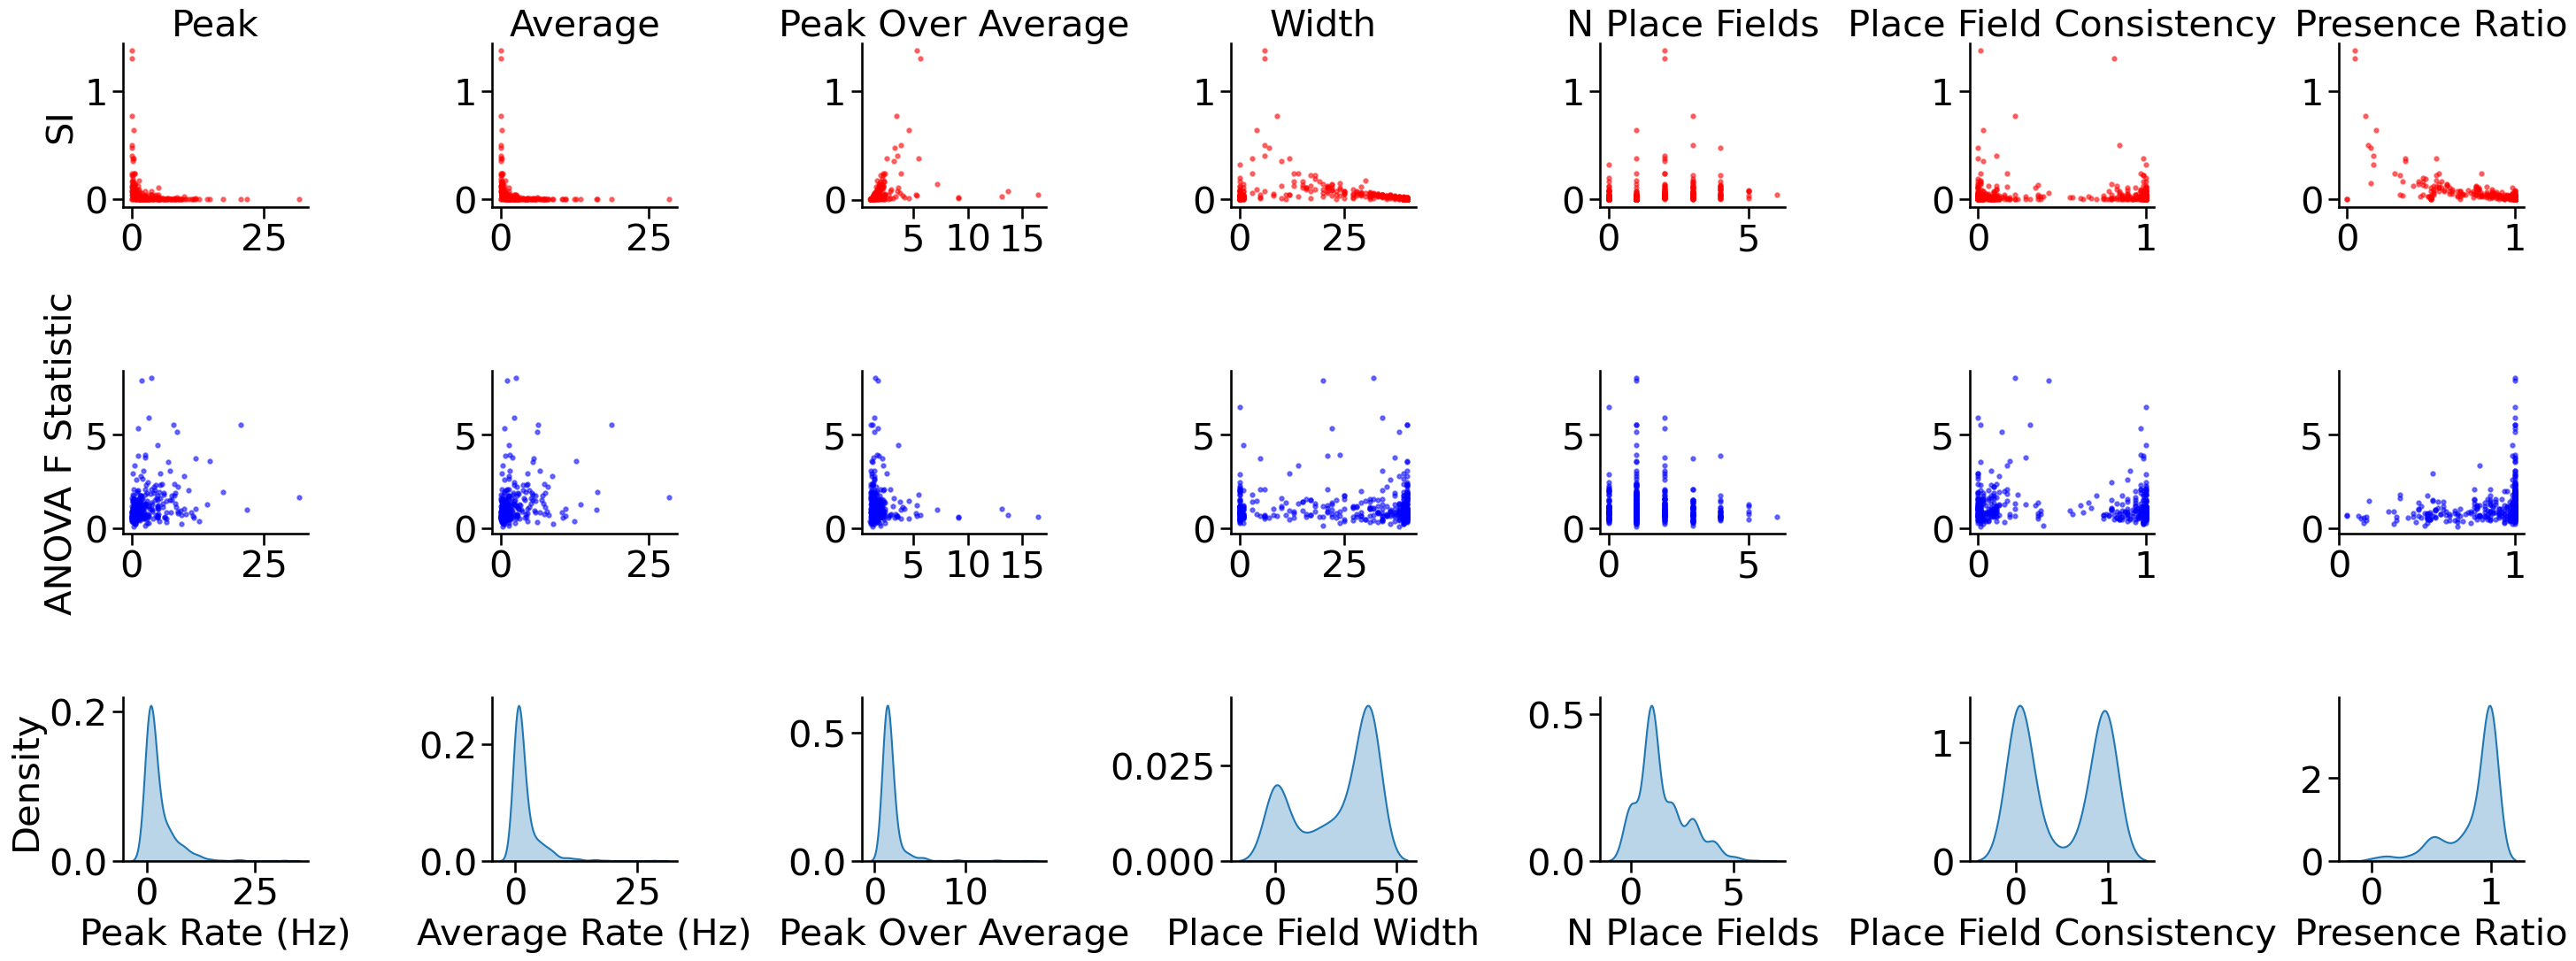

In [17]:
grid = make_grid(3, 7, wspace=1, hspace=1, figsize=(35,12))
plt.rcParams.update({
    'font.size': 30,
    'axes.titlesize': 30,
    'axes.labelsize': 30,
    'legend.fontsize': 30,
    'xtick.labelsize': 30,
    'ytick.labelsize': 30
})

# Define variables for scatter plot parameters
s = 10
alpha = 0.5

ax = get_grid_subplot(grid, 0, 0)
ax.scatter(peak_rate, place_info, s=s, alpha=alpha, color='red')
ax.set_ylabel('SI')
ax.set_title('Peak')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 1, 0)
ax.scatter(peak_rate, place_anova, s=s, alpha=alpha, color='blue')
ax.set_ylabel('ANOVA F Statistic')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 2, 0)
sns.kdeplot(data=peak_rate, alpha=0.3, fill=True, ax=ax)
ax.set_xlabel('Peak Rate (Hz)')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 0, 1)
ax.scatter(average_rate, place_info, s=s, alpha=alpha, color='red')
ax.set_title('Average')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 1, 1)
ax.scatter(average_rate, place_anova, s=s, alpha=alpha, color='blue')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 2, 1)
sns.kdeplot(data=average_rate, alpha=0.3, fill=True, ax=ax)
ax.set_xlabel('Average Rate (Hz)')
ax.set_ylabel('')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 0, 2)
ax.scatter(peak_over_average_rate, place_info, s=s, alpha=alpha, color='red')
ax.set_title('Peak Over Average')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 1, 2)
ax.scatter(peak_over_average_rate, place_anova, s=s, alpha=alpha, color='blue')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 2, 2)
sns.kdeplot(data=peak_over_average_rate, alpha=0.3, fill=True, ax=ax)
ax.set_xlabel('Peak Over Average')
ax.set_ylabel('')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 0, 3)
ax.scatter(place_field_width, place_info, s=s, alpha=alpha, color='red')
ax.set_title('Width')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 1, 3)
ax.scatter(place_field_width, place_anova, s=s, alpha=alpha, color='blue')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 2, 3)
sns.kdeplot(data=place_field_width, alpha=0.3, fill=True, ax=ax)
ax.set_xlabel('Place Field Width')
ax.set_ylabel('')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 0, 4)
ax.scatter(num_place_fields, place_info, s=s, alpha=alpha, color='red')
ax.set_title('N Place Fields')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 1, 4)
ax.scatter(num_place_fields, place_anova, s=s, alpha=alpha, color='blue')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 2, 4)
sns.kdeplot(data=num_place_fields, alpha=0.3, fill=True, ax=ax)
ax.set_xlabel('N Place Fields')
ax.set_ylabel('')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 0, 5)
ax.scatter(place_field_centre_consistency, place_info, s=s, alpha=alpha, color='red')
ax.set_title('Place Field Consistency')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 1, 5)
ax.scatter(place_field_centre_consistency, place_anova, s=s, alpha=alpha, color='blue')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 2, 5)
sns.kdeplot(data=place_field_centre_consistency, alpha=0.3, fill=True, ax=ax)
ax.set_xlabel('Place Field Consistency')
ax.set_ylabel('')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 0, 6)
ax.scatter(presence_ratio, place_info, s=s, alpha=alpha, color='red')
ax.set_title('Presence Ratio')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 1, 6)
ax.scatter(presence_ratio, place_anova, s=s, alpha=alpha, color='blue')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 2, 6)
sns.kdeplot(data=presence_ratio, alpha=0.3, fill=True, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('Presence Ratio')
drop_spines(['top','right'])
save_figure('Human_Estimated_Feature_vs_Method',file_path='/Users/weijiazhang/Plots/PLDM/Human')

In [35]:
# Save feature distributions to CSV for human data
# Create a DataFrame with all the features and metrics
features_df = pd.DataFrame({
    'peak_rate': peak_rate,
    'average_rate': average_rate,
    'peak_over_average': peak_over_average_rate,
    'place_field_width': place_field_width,
    'num_place_fields': num_place_fields,
    'place_field_centre_consistency': place_field_centre_consistency,
    'presence_ratio': presence_ratio,
    'place_info': place_info,
    'place_anova': place_anova,
})

output_path = '/Users/weijiazhang/Plots/PLDM/Human/human_place_features.csv'
features_df.to_csv(output_path, index=False)
print(f"Human features saved to {output_path}")




Human features saved to /Users/weijiazhang/Plots/PLDM/Human/human_place_features.csv
